# Data Cleaning 

# 1)- Import libraries 

In [1]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re    # for regular expressions 
import nltk  # for text manipulation 
from nltk.corpus import stopwords
import string 
import pandas as pd
import pickle
import numpy as np
#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# 2)- Load data

In [3]:
dataset=pd.read_csv('SMSSpamCollection.csv',delimiter='\t', quoting=3)

In [4]:
dataset=pd.read_csv('SMSSpamCollection.csv',delimiter='\t', quoting=3,names=['label','sms'])
dataset.head()

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
dataset.shape

(5574, 2)

# 3) Text Cleaning

- Remove unwanted text patterns
- Removing Handles (@user)
- Removing Punctuations, Numbers, and Special Characters
- Removing Short Words
- Text Normalization (tokenize+Lemmatize)


### 3.1)-remove unwanted text patterns

In [6]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

We will remove the sms handles as they are already masked as @user due to privacy concerns. These handles hardly give any information about the nature of the sms. Traditionally, they are used in twitter but, we can find them with text data as well

We will also get rid of the punctuations, numbers and even special characters since they wouldn’t help in differentiating different types of tweets.

Most of the smaller words do not add much value. For example, ‘pdx’, ‘his’, ‘all’. So, we will try to remove them as well from our data.

Lastly, we will normalize the text data. For example, reducing terms like loves, loving, and lovable to their base word, i.e., ‘love’.are often used in the same context. If we can reduce them to their root word, which is ‘love’. It will help in reducing the total number of unique words in our data without losing a significant amount of information.

### 3.2)- Removing Handles (@user)

In [7]:
dataset['clean'] = np.vectorize(remove_pattern)(dataset['sms'], "@[\w]*") 
dataset.head()

,label,sms,clean
0,ham,"Go until jurong point, crazy.. Available only ...","Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","Nah I don't think he goes to usf, he lives aro..."


### 3.3) Removing Punctuations, Numbers, and Special Characters
Here we will replace everything except characters and hashtags with spaces. The regular expression “[^a-zA-Z#]” means anything except alphabets and ‘#’.

In [8]:
dataset['clean'] = dataset['clean'].str.replace("[^a-zA-Z#]", " ") 
dataset.head()

,label,sms,clean
0,ham,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only ...
1,ham,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",Nah I don t think he goes to usf he lives aro...


In [9]:
dataset['clean'][0]

'Go until jurong point  crazy   Available only in bugis n great world la e buffet    Cine there got amore wat   '

In [10]:
dataset['sms'][0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

### 3.4) Removing Short Words
We have to be a little careful here in selecting the length of the words which we want to remove. So, I have decided to remove all the words having length 3 or less. For example, terms like “hmm”, “oh” are of very little use. It is better to get rid of them.

In [11]:
dataset['clean'] = dataset['clean'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [12]:
dataset['clean'][2]

'Free entry wkly comp final tkts Text receive entry question rate apply over'

In [13]:
dataset['sms'][2]

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

### 3.5) Text Normalization (tokenize+Lemmatize)
Here we will use nltk’s WordNetLemmatizer() function to normalize the tweets. But before that we will have to tokenize the tweets. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.

In [14]:
tokenized_sms = dataset['clean'].apply(lambda x: x.split()) # tokenizing 
tokenized_sms.head()

0    [until, jurong, point, crazy, Available, only,...
1                                             [Joking]
2    [Free, entry, wkly, comp, final, tkts, Text, r...
3                               [early, already, then]
4           [think, goes, lives, around, here, though]
Name: clean, dtype: object

In [15]:
import nltk
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()

lemm_sms = tokenized_sms.apply(lambda x: [lemm.lemmatize(i) for i in x])

In [16]:
print(lemm_sms[2])

['Free', 'entry', 'wkly', 'comp', 'final', 'tkts', 'Text', 'receive', 'entry', 'question', 'rate', 'apply', 'over']


In [17]:
dataset['sms'][2]

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

Now let’s stitch these tokens back together

In [18]:
for i in range(len(tokenized_sms)):
    lemm_sms[i] = ' '.join(lemm_sms[i])    
dataset['clean'] = lemm_sms

In [19]:
dataset.head()

,label,sms,clean
0,ham,"Go until jurong point, crazy.. Available only ...",until jurong point crazy Available only bugis ...
1,ham,Ok lar... Joking wif u oni...,Joking
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry wkly comp final tkts Text receive e...
3,ham,U dun say so early hor... U c already then say...,early already then
4,ham,"Nah I don't think he goes to usf, he lives aro...",think go life around here though


**We can do all in one step as well**

In [21]:
from nltk.corpus import stopwords
corpus = [] # defining corpus
for i in range(0, len(dataset['sms'])): # giving range of values from 0 to 1000
    sms = re.sub('[^a-zA-Z]', ' ', dataset['sms'][i]) # using i for all values instead of 1 column
    sms = sms.lower()
    sms = sms.split()
    lemm = WordNetLemmatizer()
    stopword_set = set(stopwords.words('english'))
    sms = [lemm.lemmatize(word) for word in sms if not word in stopword_set]
    sms = ' '.join(sms)
    corpus.append(sms) # finally attach all these cleaned values to corpus directory

In [22]:
type(corpus)

list

In [23]:
# convert to series to check words
sms_corpus_clean = pd.Series(corpus)

In [24]:
dataset['cleaned'] = sms_corpus_clean
dataset.head()

,label,sms,clean,cleaned
0,ham,"Go until jurong point, crazy.. Available only ...",until jurong point crazy Available only bugis ...,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,Joking,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry wkly comp final tkts Text receive e...,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,early already then,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",think go life around here though,nah think go usf life around though


I have intentionally named new column. so, we have clean and cleaned. One may make comparsion as well.

### Save work so far

In [25]:
import pickle
dataset.to_pickle('data_clean.pkl')
pickle.dump(sms_corpus_clean, open("sms_corpus_clean.pkl", "wb"))

# 4)- Visualization

### 4.1) Understanding the common words used

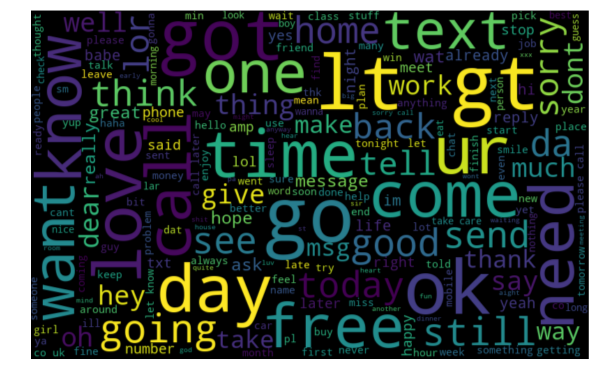

In [26]:
from wordcloud import WordCloud
all_words = ' '.join([text for text in dataset['cleaned']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### 4.2) Words in spam

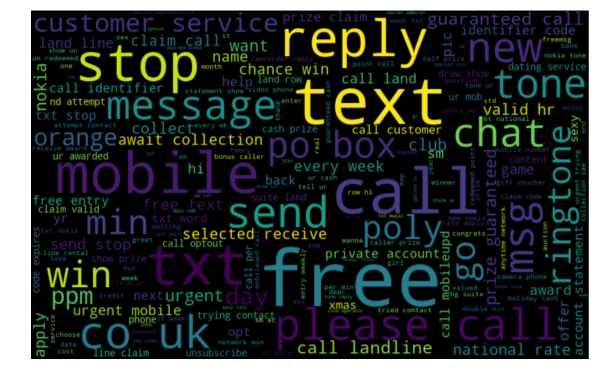

In [27]:
normal_words =' '.join([text for text in dataset['cleaned'][dataset['label'] == 'spam']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### 4.3) Words in non-spam

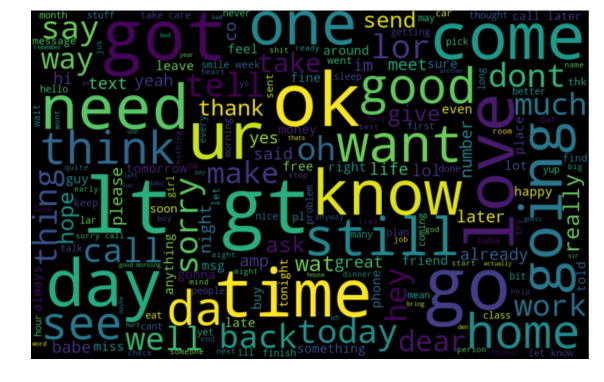

In [28]:
normal_words =' '.join([text for text in dataset['cleaned'][dataset['label'] == 'ham']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()